In [69]:
import numpy as np

In [70]:
X_train, y_train, X_test, y_test, X_dev, y_dev = np.load('./tcnn_features.npy', allow_pickle = True)

In [ ]:
X_train[0]

In [71]:
def make_X(x):
    res = []
    x = x[767:]
    for i in range(0, x.shape[0], 768):
#         print(i)
        res.append(np.array(x[i:i+768]))
    print(np.array(res).shape)
    return np.array(res)

In [72]:
X_train, X_test, X_dev = make_X(X_train), make_X(X_test), make_X(X_dev)

(9989, 768)
(2610, 768)
(1109, 768)


In [80]:
np.max(X_train), np.min(X_train)

(1.0, -1.0)

In [35]:
from sklearn import preprocessing

min_max_scaler = preprocessing.StandardScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)
X_dev = min_max_scaler.transform(X_dev)

In [36]:
num_classes = 7
time_step = 30

In [37]:
def expand_on_time(X, timestep = time_step):
    tmp = np.reshape(X[0], (1, len(X[0])))
#     print(tmp.shape)
    tmp = np.repeat(tmp, timestep, axis = 0)
#     print(tmp.shape)
    ab = np.reshape(tmp, (1, len(tmp[:,:]), len(tmp[0])))
#     print(ab.shape)
#     print(X.shape)
    X = np.repeat(ab, X.shape[0], axis = 0)
#     print(X.shape)
    return X

In [38]:
X_train, X_test, X_dev = expand_on_time(X_train), expand_on_time(X_test), expand_on_time(X_dev)

In [39]:
import pandas as pd

loly = pd.DataFrame(y_train, columns = range(0,7))

In [40]:
arousal = {
    'high' : [[1, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0]],
    'low' : [[0, 0, 0, 0, 0, 1, 0]]
}

In [41]:
l = [0, 0]

for y in y_train:
    
    if list(y) in arousal['high']:
        l[0] += 1
    if list(y) in arousal['low']:
        l[1] += 1
l

[1648, 683]

In [42]:
arr = [4.0, 15.0, 15.0, 3.0, 1.0, 6.0, 3.0]

In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, LSTM, Bidirectional, Input
from tensorflow.keras.optimizers import RMSprop, SGD

In [44]:
X_train.shape

(9989, 30, 768)

In [62]:
import tensorflow as tf

with tf.device('/GPU:0'):

    model = Sequential()
    model.add(LSTM(64, input_shape=(time_step, 768), return_sequences=True))
#     model.add(LSTM(10))
    model.add(Dropout(0.1))
    model.add(LSTM(32))
    model.add(Dropout(0.1))
#     model.add(LSTM(150, return_sequences = True))
#     model.add(LSTM(32))
#     model.add(Dropout(0.5))
    # model.add(Activation('softmax'))
    # model.add(Dense(32, activation = 'tanh'))
    # model.add(Dropout(0.4))
#     model.add(Input(shape = (768,)))
#     model.add(Dense(512, activation = 'relu'))
#     model.add(Dense(256, activation = 'relu'))
#     model.add(Dense(128, activation = 'relu'))
#     model.add(Dropout(0.5))
#     model.add(Dense(64, activation = 'relu'))
    model.add(Dense(32, activation = 'relu'))
    model.add(Dense(num_classes, activation = 'softmax'))

    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    #rms = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

    model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

In [63]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 30, 64)            213248    
_________________________________________________________________
dropout_6 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 231       
Total params: 226,951
Trainable params: 226,951
Non-trainable params: 0
________________________________________________

In [64]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=10)


In [65]:
class_weights = {}

for i in range(7):
    class_weights[i] = arr[i]

In [66]:
class_weights

{0: 4.0, 1: 15.0, 2: 15.0, 3: 3.0, 4: 1.0, 5: 6.0, 6: 3.0}

In [68]:
ist = model.fit(X_train, y_train,
                   validation_data = (X_dev, y_dev), 
#                    validation_set = 0.6,
                   verbose=1, 
                   epochs=10, batch_size=32, 
                   shuffle=True, callbacks=[early_stopping],
                   class_weight = class_weights)

Epoch 1/10
313/313 [==============================] - 6s 18ms/step - loss: 5.9161 - accuracy: 0.2218 - val_loss: 1.8910 - val_accuracy: 0.1470
Epoch 2/10
313/313 [==============================] - 6s 19ms/step - loss: 5.8715 - accuracy: 0.1886 - val_loss: 1.8945 - val_accuracy: 0.1470
Epoch 3/10
313/313 [==============================] - 6s 19ms/step - loss: 5.8691 - accuracy: 0.1919 - val_loss: 1.8912 - val_accuracy: 0.1470
Epoch 4/10
313/313 [==============================] - 6s 19ms/step - loss: 5.8697 - accuracy: 0.1865 - val_loss: 1.8917 - val_accuracy: 0.1470
Epoch 5/10
313/313 [==============================] - 6s 20ms/step - loss: 5.8679 - accuracy: 0.1789 - val_loss: 1.8829 - val_accuracy: 0.1470
Epoch 6/10
313/313 [==============================] - 6s 19ms/step - loss: 5.8660 - accuracy: 0.1938 - val_loss: 1.8904 - val_accuracy: 0.1470
Epoch 7/10
313/313 [==============================] - 6s 19ms/step - loss: 5.8666 - accuracy: 0.1914 - val_loss: 1.8911 - val_accuracy: 0.1470

KeyboardInterrupt: 

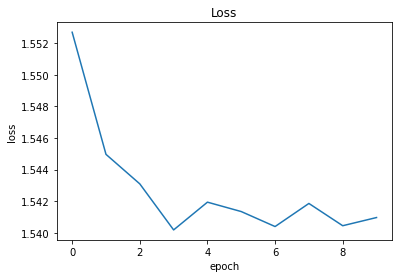

In [51]:
import matplotlib.pyplot as plt

plt.figure()
# plt.subplot(1, 2, 1)
plt.plot(ist.history['loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [52]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.8125804662704468
Test accuracy: 0.13218390941619873


In [53]:
def get_tfarray(arr):
    result = []
    for i in arr:
        m = np.max(i)
        result.append(i == m)
    return np.array(result)

In [54]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
class_names = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']


y_pred = model.predict(X_test)

y_pred = get_tfarray(y_pred)

accuracy_score(y_test, y_pred, normalize=False)
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))

              precision    recall  f1-score   support

       anger     0.1322    1.0000    0.2335       345
     disgust     0.0000    0.0000    0.0000        68
        fear     0.0000    0.0000    0.0000        50
         joy     0.0000    0.0000    0.0000       402
     neutral     0.0000    0.0000    0.0000      1256
     sadness     0.0000    0.0000    0.0000       208
    surprise     0.0000    0.0000    0.0000       281

   micro avg     0.1322    0.1322    0.1322      2610
   macro avg     0.0189    0.1429    0.0334      2610
weighted avg     0.0175    0.1322    0.0309      2610
 samples avg     0.1322    0.1322    0.1322      2610



/home/anuragpendyala.31/anaconda3/envs/ser2/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [55]:
from sklearn.metrics import confusion_matrix
#Get the confusion matrix


#array([[1, 0, 0],
#   [1, 0, 0],
#   [0, 1, 2]])
cm =confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
#Now the normalize the diagonal entries
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#array([[1.        , 0.        , 0.        ],
#      [1.        , 0.        , 0.        ],
#      [0.        , 0.33333333, 0.66666667]])

#The diagonal entries are the accuracies of each class
cm.diagonal()

array([1., 0., 0., 0., 0., 0., 0.])

In [56]:
predictions = model.predict(X_test)

In [57]:
y_test[0], predictions[0]

(array([0, 0, 0, 0, 0, 0, 1]),
 array([0.18581344, 0.06545026, 0.13350077, 0.16205575, 0.1793325 ,
        0.14005865, 0.13378865], dtype=float32))

In [61]:
y_test[10], predictions[10]

(array([0, 0, 0, 1, 0, 0, 0]),
 array([0.18581344, 0.06545026, 0.13350077, 0.16205575, 0.1793325 ,
        0.14005865, 0.13378865], dtype=float32))

In [59]:
np.argmax(y_test, axis = 1), np.argmax(predictions, axis = 1)

(array([6, 0, 4, ..., 4, 4, 4]), array([0, 0, 0, ..., 0, 0, 0]))

In [60]:
pd.DataFrame(np.argmax(predictions, axis = 1)).value_counts()

0    2610
dtype: int64